In [1]:
import tensorflow as tf
import numpy as np
import joblib
import os.path
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_crossentropy
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import os
import shutil
import random
import scipy
import glob
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

2023-03-13 15:22:10.367183: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-13 15:22:10.557406: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-13 15:22:10.563052: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-13 15:22:10.563087: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

Load the resnet model from keras

In [2]:
resnet_50_model = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

2023-03-13 15:22:17.986455: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-03-13 15:22:17.986505: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (divya-Inspiron-15-5518): /proc/driver/nvidia/version does not exist
2023-03-13 15:22:17.987844: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
train_path = 'model_data/train/sagittal'
valid_path = 'model_data/valid/sagittal'

In [4]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224, 224), batch_size=10, classes=['AD', 'CN', 'MCI'])
 
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224, 224), batch_size=10, classes=['AD', 'CN', 'MCI'], shuffle=False)

Found 1350 images belonging to 3 classes.
Found 580 images belonging to 3 classes.


In [5]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [6]:
imgs, labels = next(train_batches)

Currently the trainable parameters are: 23,534,592 which is not required for our current task.

In [7]:
resnet_50_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

We can see that the model is a Functional API model.

In [8]:
type(resnet_50_model)

keras.engine.functional.Functional

We flatten the input to the model and then pass it to the output layer, which is a new Dense Layer with a two neurons. The output layer is the final layer of the model.

In [9]:
# Flatten output layer of Resnet
flattened = tf.keras.layers.Flatten()(resnet_50_model.output)

#Fully connected layer, output layer
fc2 = tf.keras.layers.Dense(3, activation='sigmoid', name="AddedDense1")(flattened)

model = tf.keras.models.Model(inputs=resnet_50_model.input, outputs=fc2)

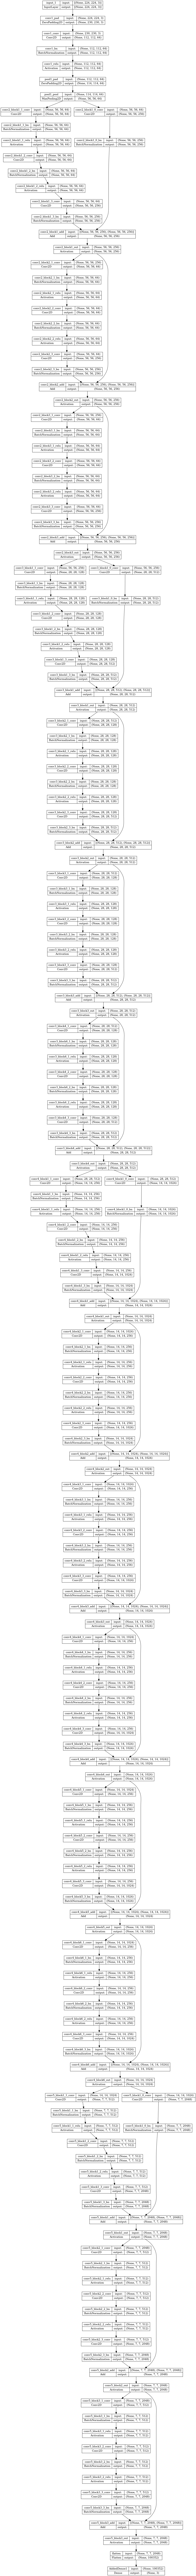

In [11]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_plot_resnet.png', show_shapes=True, show_layer_names=True)

Apart from the 'AddedDense1' Layer that we created, all the rest of the layers are frozen.

In [43]:
for layer in model.layers:
    if layer.name == 'AddedDense1':
        break
    layer.trainable = False

In [45]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [46]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [58]:
from keras.callbacks import LearningRateScheduler

def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 20:
        lr *= 0.1
    return lr

callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
    min_delta=0,
    patience=3,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True)

if os.path.isfile('models/adni_resnet_multi.h5'):
    model = load_model('models/adni_resnet_multi.h5')
    history = joblib.load('models/history/adni_resnet_multi.pkl')
else:
    history = model.fit(x=train_batches, steps_per_epoch=train_batches.n//train_batches.batch_size, validation_data=valid_batches, validation_steps=valid_batches.n//valid_batches.batch_size, epochs=50, verbose=2, callbacks=[callback, LearningRateScheduler(lr_schedule)])
    joblib.dump(history, 'models/history/adni_resnet_multi.pkl')
    
    model.save('models/adni_resnet_multi.h5')

Epoch 1/50
135/135 - 140s - loss: 2.0348 - accuracy: 0.8822 - val_loss: 4.5758 - val_accuracy: 0.8190 - lr: 0.0010 - 140s/epoch - 1s/step
Epoch 2/50
135/135 - 147s - loss: 0.8662 - accuracy: 0.9356 - val_loss: 1.7592 - val_accuracy: 0.8759 - lr: 0.0010 - 147s/epoch - 1s/step
Epoch 3/50
135/135 - 147s - loss: 1.1501 - accuracy: 0.9170 - val_loss: 3.0003 - val_accuracy: 0.8793 - lr: 0.0010 - 147s/epoch - 1s/step
Epoch 4/50
135/135 - 148s - loss: 0.8783 - accuracy: 0.9496 - val_loss: 1.8860 - val_accuracy: 0.8948 - lr: 0.0010 - 148s/epoch - 1s/step
Epoch 5/50
135/135 - 149s - loss: 0.0819 - accuracy: 0.9896 - val_loss: 1.5450 - val_accuracy: 0.9138 - lr: 0.0010 - 149s/epoch - 1s/step
Epoch 6/50
135/135 - 153s - loss: 0.1746 - accuracy: 0.9800 - val_loss: 3.4004 - val_accuracy: 0.8310 - lr: 0.0010 - 153s/epoch - 1s/step
Epoch 7/50
135/135 - 151s - loss: 0.2025 - accuracy: 0.9807 - val_loss: 3.9118 - val_accuracy: 0.8190 - lr: 0.0010 - 151s/epoch - 1s/step
Epoch 8/50
Restoring model weights

# Tracking Convergence

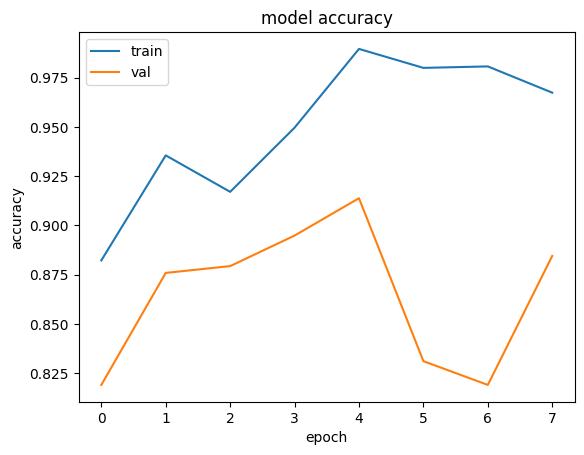

In [69]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

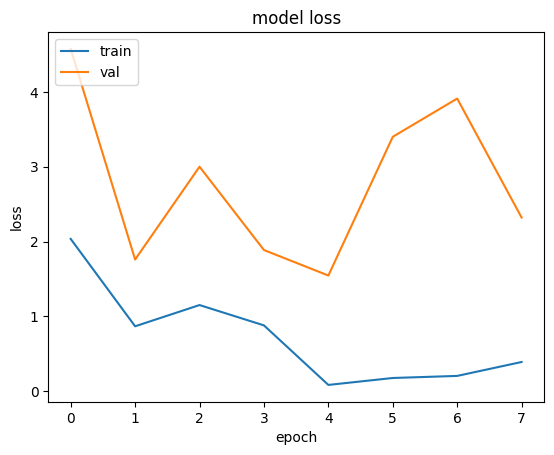

In [70]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [71]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

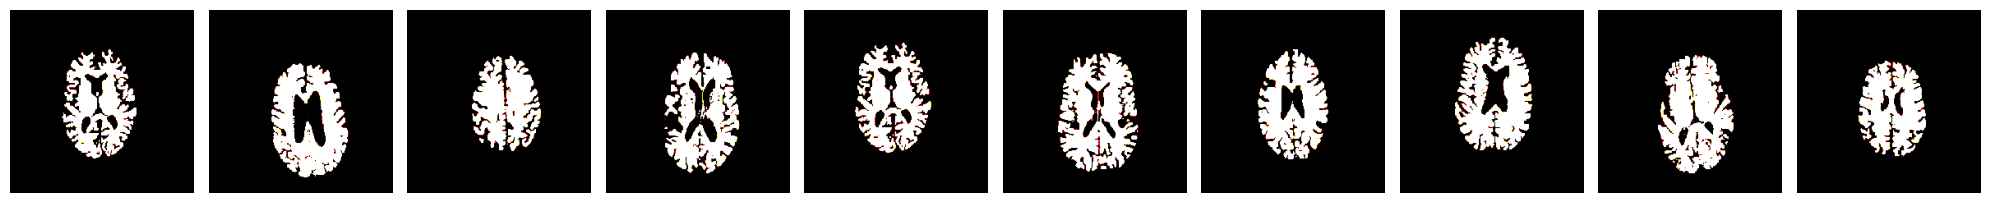

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [72]:
test_imgs, test_labels = next(valid_batches)
plotImages(test_imgs)
print(test_labels)

In [73]:
predictions = model.predict(x=valid_batches, verbose=0)

In [74]:
cm = confusion_matrix(y_true=valid_batches.classes, y_pred=np.argmax(predictions, axis=1))

In [75]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:.2f}%".format(cm[i, j] * 100),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [76]:
valid_batches.class_indices

{'AD': 0, 'CN': 1, 'MCI': 2}

Confusion matrix for the model is shown below, where the diagonal elements are the true positives, the off-diagonal elements are the false positives.

Normalized confusion matrix
[[0.856      0.064      0.08      ]
 [0.02873563 0.96551724 0.00574713]
 [0.00711744 0.15302491 0.83985765]]


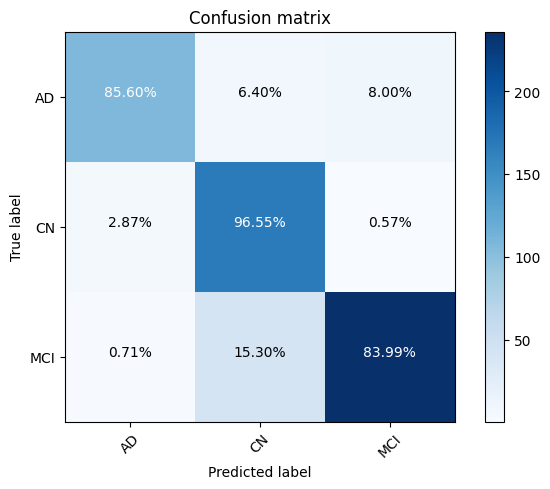

In [77]:
cm_plot_labels = valid_batches.class_indices.keys()
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion matrix', normalize=True)

In [78]:
from sklearn import metrics

print(metrics.classification_report(valid_batches.classes, np.argmax(predictions, axis=-1), target_names=cm_plot_labels))

              precision    recall  f1-score   support

          AD       0.94      0.86      0.90       125
          CN       0.77      0.97      0.85       174
         MCI       0.96      0.84      0.89       281

    accuracy                           0.88       580
   macro avg       0.89      0.89      0.88       580
weighted avg       0.90      0.88      0.88       580

